In [1]:
%cd ~/codeProjects/pythonProjects/Bayesian-Learning-with-Wasserstein-Barycenters

/home/fmunoz/codeProjects/pythonProjects/Bayesian-Learning-with-Wasserstein-Barycenters


# Función de autocorrelación

In [2]:
import torch

__all__ = ["function_1d", "integrated_time", "AutocorrError"]



def next_pow_two(n):
    """Returns the next power of two greater than or equal to `n`"""
    i = 1
    while i < n:
        i = i << 1
    return i


def function_1d(x):
    """Estimate the normalized autocorrelation function of a 1-D series

    Args:
        x: The series as a 1-D PyTorch tensor.

    Returns:
        tensor: The autocorrelation function of the time series.

    """
    x = torch.atleast_1d(x)
    if len(x.shape) != 1:
        raise ValueError("invalid dimensions for 1D autocorrelation function")
    n = next_pow_two(len(x))

    # Transfer input tensor to the appropriate device (e.g., GPU)
    device = x.device

    # Compute the FFT and then (from that) the auto-correlation function
    f = torch.fft.fft(x - torch.mean(x), n=2 * n)
    acf = torch.fft.ifft(f * torch.conj(f))[: len(x)].real
    acf /= acf[0].item()

    # Transfer the result back to the original device (if necessary)
    acf = acf.to(device)

    return acf


def auto_window(taus, c, device=None):
    if device is None:
        device = taus.device

    m = torch.arange(len(taus), device=device) < c * taus
    if torch.any(m):
        return torch.argmin(m.long()).item()
    return len(taus) - 1


def integrated_time(x, c=5, tol=50, quiet=False, has_walkers=True, device=None):
    """Estimate the integrated autocorrelation time of a time series.

    This estimate uses the iterative procedure described on page 16 of
    `Sokal's notes <https://www.semanticscholar.org/paper/Monte-Carlo-Methods-in-Statistical-Mechanics%3A-and-Sokal/0bfe9e3db30605fe2d4d26e1a288a5e2997e7225>`_ to
    determine a reasonable window size.

    Args:
        x (torch.Tensor): The time series. If 2-dimensional, the tensor
            dimensions are interpreted as ``(n_step, n_walker)`` unless
            ``has_walkers==False``, in which case they are interpreted as
            ``(n_step, n_param)``. If 3-dimensional, the dimensions are
            interpreted as ``(n_step, n_walker, n_param)``.
        c (Optional[float]): The step size for the window search. (default:
            ``5``)
        tol (Optional[float]): The minimum number of autocorrelation times
            needed to trust the estimate. (default: ``50``)
        quiet (Optional[bool]): This argument controls the behavior when the
            chain is too short. If ``True``, give a warning instead of raising
            an :class:`AutocorrError`. (default: ``False``)
        has_walkers (Optional[bool]): Whether the last axis should be
            interpreted as walkers or parameters if ``x`` has 2 dimensions.
            (default: ``True``)
        device (Optional[torch.device]): The target device for computation.
            If not specified, the device of the input tensor `x` will be used.

    Returns:
        float or tensor: An estimate of the integrated autocorrelation time of
            the time series ``x``.

    Raises
        AutocorrError: If the autocorrelation time can't be reliably estimated
            from the chain and ``quiet`` is ``False``. This normally means
            that the chain is too short.

    """
    # Check if a device is specified, otherwise use the device of the input tensor
    if device is None:
        device = x.device

    x = torch.atleast_1d(x.to(device))
    if len(x.shape) == 1:
        x = x[:, None, None]
    if len(x.shape) == 2:
        if not has_walkers:
            x = x[:, None, :]
        else:
            x = x[:, :, None]
    if len(x.shape) != 3:
        raise ValueError("invalid dimensions")

    n_t, n_w, n_d = x.shape
    tau_est = torch.empty(n_d, device=device)
    windows = torch.empty(n_d, dtype=torch.int, device=device)

    # Loop over parameters
    for d in range(n_d):
        f = torch.zeros(n_t, device=device)
        for k in range(n_w):
            f += function_1d(x[:, k, d])
        f /= n_w
        taus = 2.0 * torch.cumsum(f, dim=0) - 1.0
        taus = taus.to(device)
        windows[d] = auto_window(taus, c)
        tau_est[d] = taus[windows[d]]

    # Check convergence
    flag = tol * tau_est > n_t

    # Warn or raise in the case of non-convergence
    if torch.any(flag):
        msg = (
            "The chain is shorter than {0} times the integrated "
            "autocorrelation time for {1} parameter(s). Use this estimate "
            "with caution and run a longer chain!\n"
        ).format(tol, torch.sum(flag))
        msg += "N/{0} = {1:.0f};\ntau: {2}".format(tol, n_t / tol, tau_est)
        if not quiet:
            raise AutocorrError(tau_est.cpu(), msg)

    return tau_est


class AutocorrError(Exception):
    """Raised if the chain is too short to estimate an autocorrelation time.

    The current estimate of the autocorrelation time can be accessed via the
    ``tau`` attribute of this exception.

    """

    def __init__(self, tau, *args, **kwargs):
        self.tau = tau
        super(AutocorrError, self).__init__(*args, **kwargs)

# Posterior Explícita

In [3]:
import numpy as np

from bwb.distributions.data_loaders import DistributionDrawDataLoader
from bwb.distributions import ExplicitPosteriorPiN

expl_posterior = ExplicitPosteriorPiN()
expl_posterior

ExplicitPosteriorPiN()

In [4]:
from pathlib import Path

data_path = Path("./data/face.npy")

models_array = np.load(data_path)
n_faces, _ = models_array.shape
print(f"{n_faces = }")

faces = DistributionDrawDataLoader(models_array, (28, 28))

n_faces = 161666


In [5]:
face0 = faces[0]
face0

In [6]:
import torch
torch.manual_seed(42)

data = x = faces[0].sample((50,))
x

tensor([478,  91, 298, 116, 188, 332, 593, 300, 354, 255, 239, 659, 627,  96,
        294, 126, 603, 247, 353, 227,  91, 637, 685, 157, 217, 323, 118, 337,
        662, 290, 118, 244, 529, 244, 204, 633, 246, 227, 124, 602, 474, 275,
        688, 326, 659, 571, 145, 622, 154, 474], device='cuda:0')

In [7]:
%%time
expl_posterior.fit(x, faces)

CPU times: user 2.33 ms, sys: 1.37 ms, total: 3.71 ms
Wall time: 3.06 ms


ExplicitPosteriorPiN(n_data=50, n_models=161666, n_support=15194)

In [8]:
%%time
expl_posterior.rvs(size=1000, seed=42)
print()


CPU times: user 501 ms, sys: 102 ms, total: 603 ms
Wall time: 603 ms


In [9]:
expl_posterior.total_time

0.6024074909996671

In [10]:
expl_posterior2 = ExplicitPosteriorPiN()
expl_posterior2.total_time, expl_posterior.total_time

(0.0, 0.6024074909996671)

In [11]:
try:
    expl_posterior2.draw()
except Exception as e:
    print(e)

This ExplicitPosteriorPiN instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.


In [12]:
len(expl_posterior.samples_counter)

1000

In [13]:
print(expl_posterior.samples_counter.total())
expl_posterior.draw()
print(expl_posterior.samples_counter.total())

1000
1001


In [14]:
expl_posterior.draw()

In [15]:
del expl_posterior, expl_posterior2, faces, models_array, data, x

# Importar redes

In [16]:
from wgan_gp.wgan_gp_vae.model_resnet import Generator, Encoder
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
LATENT_DIM = 128
CHANNELS_IMG = 1
NUM_FILTERS = [256, 128, 64, 32]

G = Generator(LATENT_DIM, CHANNELS_IMG).to(device)
E = Encoder(LATENT_DIM, CHANNELS_IMG).to(device)

CURR_PATH = Path(".")
NETS_PATH = CURR_PATH / "wgan_gp" / "networks" 
FACE_PATH = NETS_PATH / f"_resnet_face_zDim{LATENT_DIM}_gauss_bs_128_recognized_augmented_WAE_WGAN_loss_l1_32p32"

from wgan_gp.wgan_gp_vae.utils import load_checkpoint

load_checkpoint(G, FACE_PATH, "generator", device)
load_checkpoint(E, FACE_PATH, "encoder", device)

G.eval(), E.eval()
print()

In [17]:
face0.grayscale_weights.shape

torch.Size([28, 28])

In [18]:
from torchvision import disable_beta_transforms_warning
disable_beta_transforms_warning()

import torchvision.transforms.v2 as T

z = G.sample_noise(1)
m = G(z)
transform_in = T.Compose([
    T.Lambda(lambda x: x / torch.max(x)),
    T.ToPILImage(),
    T.Resize(32),
    T.ToImageTensor(),
    T.ConvertImageDtype(torch.float32),
    T.Normalize((0.5,), (0.5,)),
])
transform_out = T.Compose([
    T.Lambda(lambda x: x.squeeze()),
    T.Lambda(lambda x: x - torch.min(x)),
    T.Lambda(lambda x: x / torch.sum(x)),
])
transform_out(m)

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]], device='cuda:0',
       grad_fn=<DivBackward0>)

seed = 4102165607616432379
data = tensor([345, 606, 787, 839, 775, 825, 546, 820, 763, 338, 305, 210, 842, 373,
        380, 730, 166, 247, 790, 541, 759, 433, 853, 228, 541, 330, 469, 850,
        464, 434, 464, 772, 303, 817, 878, 707, 259, 786, 280, 170, 354, 437,
        843, 434, 501, 541, 747, 139, 820, 747, 877, 713, 296, 821, 338, 387,
        196, 745, 500, 855, 712, 332, 781, 401, 248, 379, 437, 580, 877, 213,
        680, 915, 700, 267, 361, 821, 572, 331, 198, 578, 395, 338, 406, 329,
        787, 313, 917, 137, 170, 328, 792, 337, 305, 731, 331, 779, 885, 513,
        844, 378], device='cuda:0')


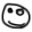

In [19]:
import bwb.distributions as bwb_dist
seed = 4102165607616432379
print(f"{seed = }")
torch.manual_seed(seed)

with torch.no_grad():
    m = transform_in(face0.grayscale_weights).unsqueeze(0).to(device)
    z = E(m)
    m = G(z)

m = transform_out(m)

face = bwb_dist.DistributionDraw.from_grayscale_weights(m)
data = face.sample((100,))
print(f"{data = }")
face

# MCMC

![](https://quicklatex.com/cache3/e9/ql_ee61247290f642a5afc1fc6205cc98e9_l3.png)

In [20]:
def _log_prior(z: torch.Tensor, radius=3):
    """
    Compute the log-prior of the latent variable z.
    .. math::
        \log \Pi_Z(z) = -\frac{1}{2} \|z\|^2
    """
    z = z.squeeze()
    min_value = torch.finfo(z.dtype).min
    norm_z_2 = torch.sum(z ** 2)  # \|z\|^2
    n = z.shape[0]
    const = 0 if norm_z_2 / n < radius ** 2 else min_value  # if the norm of z is too big, the likelihood is 0
    return -norm_z_2 / 2 + const  # -\frac{1}{2} \|z\|^2


def _log_likelihood_latent(z: torch.Tensor, data:torch.Tensor, generator: torch.nn.Module, transform_out):
    """
    Compute the log-likelihood of the data given the latent variable z.
    This is done by first generating the image x from z, then transforming it to a DistributionDraw object.
    
    The original likelihood is:
    .. math::
        \Pi_n(dm)
        \propto \Pi(dm) \mathcal{L}_n(m)
        = \int_{\mathcal{Z}} P_Z(dz) \Pi(dm | z) \mathcal{L}_n(m)
        \propto \int_{\mathcal{Z}} dz \Pi(dm | z) \mathcal{L}_n(m) e^{-\frac{1}{2} \|z\|^2}
        = \int_{\mathcal{Z}} dz \Pi(dm | z) \prod_{i=1}^n m(x_i) e^{-\frac{1}{2} \|z\|^2}

    So, the log-likelihood with respecto to z is:
    .. math::
        \ell_n(z) = \sum_{i=1}^n \log m(x_i) - \frac{1}{2} \|z\|^2
    """
    eps = torch.finfo(z.dtype).eps
    
    z = torch.reshape(z, (1, -1, 1, 1))
    with torch.no_grad():
        m = generator(z)    
    m = transform_out(m)
    m = m.reshape((-1,))
    
    # m_data = m.take(data) + eps  # to avoid log(0)
    # logits = torch.log(m_data)  # log m(x_i)
    
    m_data = m.take(data)
    m_data_zeros = m_data == 0
    m_data = m_data + eps  # to avoid log(0)
    logits = torch.log(m_data)  # log m(x_i)
    logits[m_data_zeros] = logits[m_data_zeros] * 3
    
    return torch.sum(logits) # \sum_{i=1}^n \log m(x_i)


def _log_posterior(z: torch.Tensor, data: torch.Tensor, generator: torch.nn.Module, transform_out, radius=3):
    """
    Compute the log-posterior of the latent variable z.
    .. math::
        \log \Pi_n(z) = \log \Pi_Z(z) + \log \Pi_n(dm)
    """
    return _log_prior(z, radius) + _log_likelihood_latent(z, data, generator, transform_out)

# z = G.sample_noise(1).squeeze()

_log_likelihood_latent(z, data, G, transform_out), _log_prior(z), _log_posterior(z, data, G, transform_out)

(tensor(-591.6954, device='cuda:0'),
 tensor(-53.0379, device='cuda:0'),
 tensor(-644.7333, device='cuda:0'))

In [21]:
def _log_likelihood_true_latent(z: torch.Tensor, data:torch.Tensor, generator: torch.nn.Module, transform_out):
    """
    Compute the log-likelihood of the data given the latent variable z.
    This is done by first generating the image x from z, then transforming it to a DistributionDraw object.
    
    The original likelihood is:
    .. math::
        \Pi_n(dm)
        \propto \Pi(dm) \mathcal{L}_n(m)
        = \int_{\mathcal{Z}} P_Z(dz) \Pi(dm | z) \mathcal{L}_n(m)
        \propto \int_{\mathcal{Z}} dz \Pi(dm | z) \mathcal{L}_n(m) e^{-\frac{1}{2} \|z\|^2}
        = \int_{\mathcal{Z}} dz \Pi(dm | z) \prod_{i=1}^n m(x_i) e^{-\frac{1}{2} \|z\|^2}

    So, the log-likelihood with respecto to z is:
    .. math::
        \ell_n(z) = \sum_{i=1}^n \log m(x_i) - \frac{1}{2} \|z\|^2
    """
    eps = torch.finfo(z.dtype).eps
    
    z = torch.reshape(z, (1, -1, 1, 1))
    with torch.no_grad():
        m = generator(z)    
    m = transform_out(m)
    m = m.reshape((-1,))
    
    m_data = m.take(data)
    m_data_zeros = m_data == 0
    m_data = m_data + eps  # to avoid log(0)
    logits = torch.log(m_data)  # log m(x_i)
    logits[m_data_zeros] = logits[m_data_zeros] * 10
    
    return torch.sum(logits) # \sum_{i=1}^n \log m(x_i)

_log_likelihood_true_latent(z, data, G, transform_out)

tensor(-591.6954, device='cuda:0')

In [22]:
for _ in range(10):
    z = G.sample_noise(1).squeeze()
    print(_log_likelihood_true_latent(z, data, G, transform_out), _log_prior(z), _log_posterior(z, data, G, transform_out))

tensor(-926.8901, device='cuda:0') tensor(-74.7803, device='cuda:0') tensor(-1001.6704, device='cuda:0')
tensor(-1094.4254, device='cuda:0') tensor(-56.4562, device='cuda:0') tensor(-1039.2850, device='cuda:0')
tensor(-824.5963, device='cuda:0') tensor(-54.9689, device='cuda:0') tensor(-879.5652, device='cuda:0')
tensor(-755.0569, device='cuda:0') tensor(-67.7433, device='cuda:0') tensor(-822.8002, device='cuda:0')
tensor(-1434.2817, device='cuda:0') tensor(-62.9677, device='cuda:0') tensor(-1050.8628, device='cuda:0')
tensor(-1357.2953, device='cuda:0') tensor(-72.0368, device='cuda:0') tensor(-1094.5421, device='cuda:0')
tensor(-901.3963, device='cuda:0') tensor(-56.8944, device='cuda:0') tensor(-846.6941, device='cuda:0')
tensor(-2972.7832, device='cuda:0') tensor(-66.3864, device='cuda:0') tensor(-1476.8162, device='cuda:0')
tensor(-2789.1958, device='cuda:0') tensor(-62.5484, device='cuda:0') tensor(-1400.9873, device='cuda:0')
tensor(-1075.0098, device='cuda:0') tensor(-57.7188, 

## MCMC Clase Base

In [23]:
import torch

from bwb.distributions import PosteriorPiN
from bwb.distributions.posterior_distributions import _timeit_to_total_time
from bwb.utils import _ArrayLike
import bwb.validation as bwb_val
import hamiltorch
from hamiltorch import Sampler, Integrator, Metric
import random


class LatentMCMCPosteriorPiN(PosteriorPiN[bwb_dist.DistributionDraw]):
    """
    The posterior Pi_n distribution using MCMC sampling of the latent variable z.
    """
    def __init__(
            self,
            log_prob_fn=_log_posterior,
            num_samples=10, 
            num_steps_per_sample=10, 
            burn=10,
            step_size=0.1,
            sampler=Sampler.HMC, 
            **kwargs
        ) -> None:
        super().__init__(log_prob_fn)
        self.samples_history: list[torch.Tensor] = []
        self.samples_cache: list[torch.Tensor] = []
        self.hamiltorch_kwargs = dict(
            num_samples=num_samples,
            num_steps_per_sample=num_steps_per_sample,
            burn=burn,
            step_size=step_size,
            sampler=sampler,
        )
        self.hamiltorch_kwargs.update(kwargs)
        self.hamiltorch_kwargs.setdefault("debug", 0)
    
    def fit(self, data: _ArrayLike, generator: torch.nn.Module, transform_out: T.Compose):
        super().fit(data)
        self.generator_ = generator
        self.transform_out_ = transform_out
        return self

    def log_prob(self, z: torch.Tensor):
        bwb_val.check_is_fitted(self, ["data_", "generator_", "transform_out_"])
        return self.log_likelihood_fn(z, self.data_, self.generator_, self.transform_out_)

    def reset_samples(self):
        self.samples_cache = []
        return self
    
    @_timeit_to_total_time
    def run(
            self, 
            params_init=None,
            num_samples=None, 
            burn=None,
            permut_samples=False, 
            **kwargs
        ):
        bwb_val.check_is_fitted(self, ["generator_", "transform_out_", "data_"])
        
        z_init: torch.Tensor = params_init or self.generator_.sample_noise(1).squeeze()

        hamiltorch_kwargs = self.hamiltorch_kwargs.copy()
        specific_kwargs = dict(
            log_prob_func=self.log_prob,
            params_init=z_init,
            num_samples=num_samples,
            burn=burn,
            **kwargs
        )
        hamiltorch_kwargs.update( (k, v) for k, v in specific_kwargs.items() if v is not None )
        hamiltorch_kwargs["num_samples"] = hamiltorch_kwargs["num_samples"] + hamiltorch_kwargs["burn"]
        debug = hamiltorch_kwargs["debug"]

        if debug == 2:
            samples, other = hamiltorch.sample(**hamiltorch_kwargs)
        else:
            samples = hamiltorch.sample(**hamiltorch_kwargs)

        self.samples_history.extend(samples)
        self.samples_cache.extend(samples)
        if permut_samples:
            random.shuffle(self.samples_cache)

        if debug == 2:
            return self, other
        
        return self

    def _draw(self):
        if len(self.samples_cache) == 0:
            self.run()
        z_sampled = self.samples_cache.pop(0)
        grayscale_weights = self.transform_out_(self.generator_(z_sampled.reshape(1, -1, 1, 1)).squeeze())
        return bwb_dist.DistributionDraw.from_grayscale_weights(grayscale_weights)
    
    def _rvs(self, size=1):
        if len(self.samples_cache) < size:
            self.run(num_samples=size)
        samples, self.samples_cache = self.samples_cache[:size], self.samples_cache[size:]
        samples_ = []
        for z in samples:
            grayscale_weights = self.transform_out_(self.generator_(z.reshape(1, -1, 1, 1)).squeeze())
            samples_.append(bwb_dist.DistributionDraw.from_grayscale_weights(grayscale_weights))
        return samples_

    @_timeit_to_total_time
    def draw(self) -> bwb_dist.DistributionDraw:
        return self._draw()

    @_timeit_to_total_time
    def rvs(self, size=1) -> list[bwb_dist.DistributionDraw]:
        return self._rvs(size)
    
    def _additional_repr(self):
        return ""

    def __repr__(self):
        to_return = self.__class__.__name__ + "("

        if hasattr(self, "data_"):
            to_return += f"n_data={len(self.data_)}, "

        if self.samples_history:
            to_return += f"n_total_samples={len(self.samples_history)}, "

        if self.samples_cache:
            to_return += f"n_cached_samples={len(self.samples_cache)}, "

        to_return += self._additional_repr()

        if to_return[-2:] == ", ":
            to_return = to_return[:-2]
        
        to_return += ")"

        return to_return
    
LatentMCMCPosteriorPiN()

LatentMCMCPosteriorPiN()

## Nu-U-Turn-Sampler (NUTS)

In [24]:
burn = 1_000
num_samples = 200_000

In [25]:
import bwb.utils as bwb_utils


class NUTSPosteriorPiN(LatentMCMCPosteriorPiN):
    def __init__(
            self, 
            log_prob_fn=_log_posterior, 
            num_samples=10, 
            num_steps_per_sample=10, 
            burn=10,
            step_size=0.1, 
            desired_accept_rate=0.6, 
            **kwargs
        ) -> None:
        super().__init__(
            log_prob_fn=log_prob_fn,
            num_samples=num_samples,
            num_steps_per_sample=num_steps_per_sample,
            burn=burn,
            step_size=step_size,
            sampler=Sampler.HMC_NUTS,
            desired_accept_rate=desired_accept_rate,
            **kwargs
        )

Sampling (Sampler.HMC; Integrator.IMPLICIT)
Time spent  | Time remain.| Progress             | Samples       | Samples/sec
Final Adapted Step Size:  0.242836132645607----- |    985/201000 | 59.47       
0d:00:52:48 | 0d:00:00:00 | #################### | 201000/201000 | 63.44       
Acceptance Rate 0.58



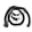
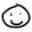
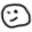
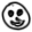
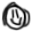
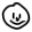
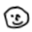
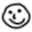
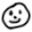
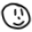
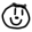
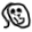
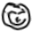
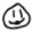
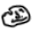
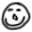
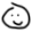
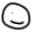
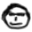
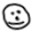
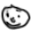
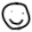
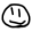
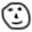
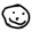
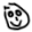
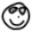
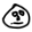
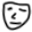
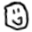
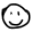
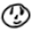
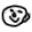
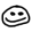
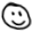
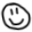
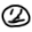
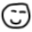
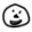
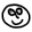
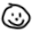
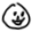
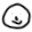
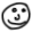
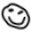
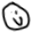
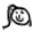
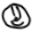
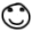


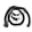
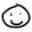
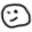
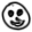
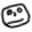
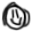
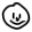
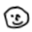
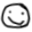
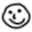
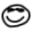
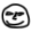
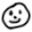
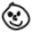
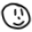
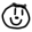
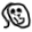
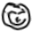
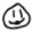
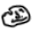
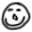
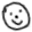
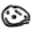
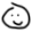
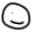
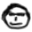
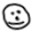
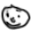
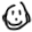
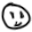
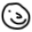
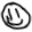
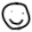
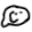
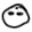
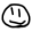
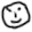
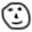
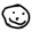
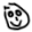
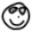
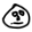
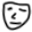
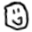
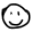
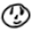
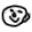
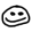
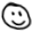
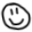
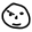
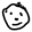
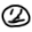
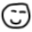
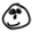
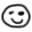
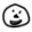
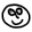
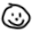
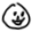
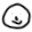
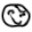
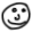
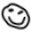
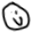
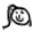
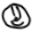
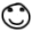

NUTSPosteriorPiN(n_data=5, n_total_samples=200000, n_cached_samples=199932)
3169.2545052650003


In [26]:
post_pi_n_5 = NUTSPosteriorPiN(debug=2, burn=burn, num_steps_per_sample=1, desired_accept_rate=0.6)
post_pi_n_5.fit(data[:5], G, transform_out)

max_images = 4 * 17
time_mixing = 1_000
_, step_size = post_pi_n_5.reset_samples().run(num_samples=num_samples, permut_samples=True)


bwb_utils.plot_list_of_draws(post_pi_n_5.rvs(max_images), max_images=max_images)

print(post_pi_n_5)
print(post_pi_n_5.total_time)

In [27]:
def auto_corr_summary(post_pi_n, c=5, tol=1_000, verbose=True):
    if not post_pi_n.samples_history:
        print("Error: samples_history is empty")
        return
    samples_history_tensor = torch.stack(post_pi_n.samples_history)[:, None, :]
    try:
        tau_est = integrated_time(samples_history_tensor, c=c, tol=tol)
    except AutocorrError as e:
        if verbose:
            print(e)
        tau_est = integrated_time(samples_history_tensor, c=c, tol=tol, quiet=True)
    print(f"Mean integrated autocorrelation time: {tau_est.mean().item():.2f} steps")

auto_corr_summary(post_pi_n_5)

Mean integrated autocorrelation time: 116.99 steps


In [28]:
data_ = data[:5]
for z in post_pi_n_5.samples_history[-10:]:
    print(_log_likelihood_true_latent(z, data_, G, transform_out), _log_prior(z), _log_posterior(z, data_, G, transform_out))

tensor(-31.0083, device='cuda:0') tensor(-68.9705, device='cuda:0') tensor(-99.9789, device='cuda:0')
tensor(-31.0083, device='cuda:0') tensor(-68.9705, device='cuda:0') tensor(-99.9789, device='cuda:0')
tensor(-31.0083, device='cuda:0') tensor(-68.9705, device='cuda:0') tensor(-99.9789, device='cuda:0')
tensor(-31.0083, device='cuda:0') tensor(-68.9705, device='cuda:0') tensor(-99.9789, device='cuda:0')
tensor(-31.2346, device='cuda:0') tensor(-69.7470, device='cuda:0') tensor(-100.9817, device='cuda:0')
tensor(-31.4296, device='cuda:0') tensor(-73.8430, device='cuda:0') tensor(-105.2726, device='cuda:0')
tensor(-31.6670, device='cuda:0') tensor(-74.2921, device='cuda:0') tensor(-105.9592, device='cuda:0')
tensor(-31.6670, device='cuda:0') tensor(-74.2921, device='cuda:0') tensor(-105.9592, device='cuda:0')
tensor(-31.1215, device='cuda:0') tensor(-71.7516, device='cuda:0') tensor(-102.8731, device='cuda:0')
tensor(-31.1215, device='cuda:0') tensor(-71.7516, device='cuda:0') tensor(-1

Sampling (Sampler.HMC; Integrator.IMPLICIT)
Time spent  | Time remain.| Progress             | Samples       | Samples/sec
Final Adapted Step Size:  0.13144733011722565--- |    988/201000 | 51.41       
0d:00:53:44 | 0d:00:00:00 | #################### | 201000/201000 | 62.33       
Acceptance Rate 0.36



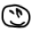
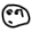
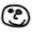
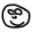
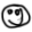
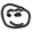
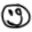
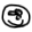
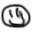
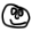
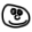
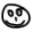
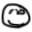
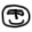
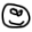
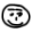
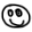
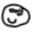
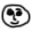
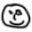
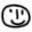
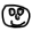
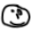
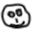
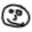
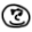
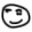
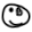
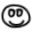
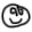
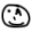
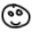
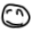
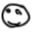
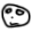
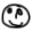
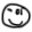
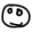
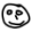
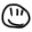
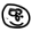
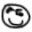
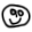
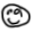
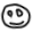
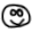
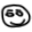
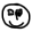
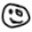
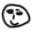
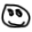
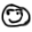
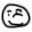
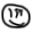
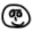
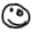
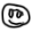
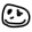
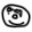
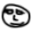


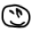
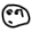
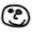
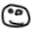
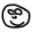
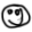
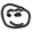
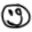
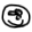
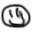
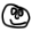
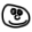
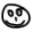
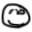
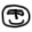
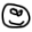
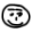
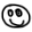
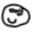
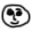
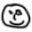
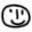
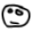
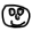
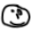
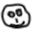
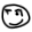
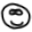
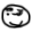
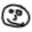
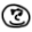
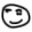
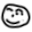
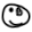
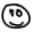
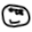
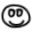
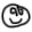
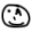
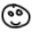
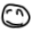
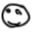
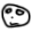
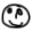
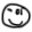
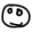
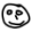
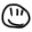
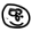
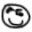
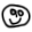
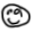
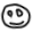
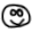
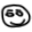
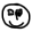
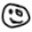
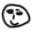
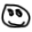
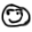
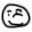
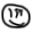
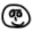
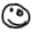
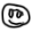
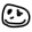
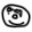
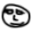

NUTSPosteriorPiN(n_data=50, n_total_samples=200000, n_cached_samples=199932)
3225.6321129299986


In [29]:
post_pi_n_50 = NUTSPosteriorPiN(debug=2, burn=burn, num_steps_per_sample=1, desired_accept_rate=0.3)
post_pi_n_50.fit(data[:50], G, transform_out)

max_images = 4*17
time_mixing = 1_000
_, step_size = post_pi_n_50.reset_samples().run(num_samples=num_samples, permut_samples=True)


bwb_utils.plot_list_of_draws(post_pi_n_50.rvs(max_images), max_images=max_images)

print(post_pi_n_50)
print(post_pi_n_50.total_time)

In [30]:
auto_corr_summary(post_pi_n_50)

The chain is shorter than 1000 times the integrated autocorrelation time for 128 parameter(s). Use this estimate with caution and run a longer chain!
N/1000 = 200;
tau: tensor([ 602.3472,  830.3035,  709.5955,  645.7798,  605.9634,  967.5880,
        1019.0328,  560.0723,  530.7786,  607.4299, 1212.3818,  565.4713,
         586.9959,  759.7371,  556.8369,  504.7104, 1000.4913,  726.2025,
         630.0225,  608.6468,  693.3229,  780.2371,  634.2278,  739.8112,
         756.2267, 1054.5902,  522.4752,  599.8879,  745.3793,  479.1651,
         521.1996,  424.1868, 1049.9475,  609.4844,  624.1285,  515.5216,
         499.1298,  730.3722,  511.9584,  709.3150,  758.9951,  602.7928,
         592.7335,  562.9203,  846.1606,  597.7026,  650.7106,  510.1750,
         596.7183,  922.0981,  708.8843,  525.9449,  720.3218,  767.1803,
         551.9938,  842.9972,  630.7874,  663.5386,  680.5478,  849.9597,
         616.9044,  671.7299,  479.2110,  960.2780,  611.2062,  699.2661,
         714.2388

In [31]:
data_ = data[:50]
for i, z in enumerate(post_pi_n_50.samples_history[-10:]):
    print(i, _log_likelihood_true_latent(z, data_, G, transform_out), _log_likelihood_latent(z, data_, G, transform_out))

0 tensor(-297.1833, device='cuda:0') tensor(-297.1833, device='cuda:0')
1 tensor(-297.1833, device='cuda:0') tensor(-297.1833, device='cuda:0')
2 tensor(-297.1833, device='cuda:0') tensor(-297.1833, device='cuda:0')
3 tensor(-299.9311, device='cuda:0') tensor(-299.9311, device='cuda:0')
4 tensor(-299.9311, device='cuda:0') tensor(-299.9311, device='cuda:0')
5 tensor(-299.9311, device='cuda:0') tensor(-299.9311, device='cuda:0')
6 tensor(-299.9311, device='cuda:0') tensor(-299.9311, device='cuda:0')
7 tensor(-297.5017, device='cuda:0') tensor(-297.5017, device='cuda:0')
8 tensor(-297.3560, device='cuda:0') tensor(-297.3560, device='cuda:0')
9 tensor(-297.3560, device='cuda:0') tensor(-297.3560, device='cuda:0')


Sampling (Sampler.HMC; Integrator.IMPLICIT)
Time spent  | Time remain.| Progress             | Samples       | Samples/sec
Final Adapted Step Size:  0.07521269470453262--- |    995/201000 | 69.65       
0d:00:55:36 | 0d:00:00:00 | #################### | 201000/201000 | 60.24       
Acceptance Rate 0.57



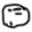
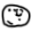
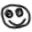
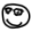
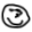
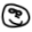
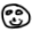
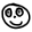
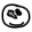
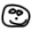
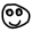
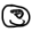
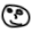
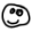
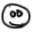
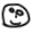
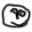
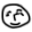
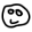
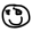
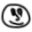
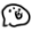
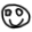
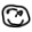
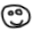
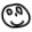
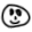
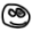
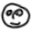
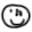
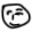
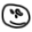
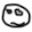
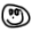
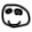
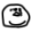
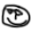
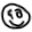
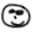
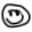
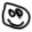
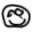
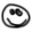
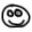
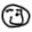
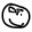
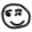
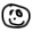
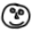
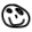
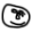
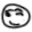
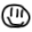
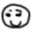
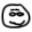
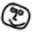
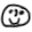
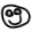
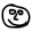
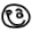
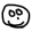
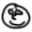
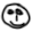
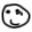
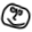
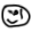
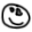
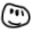


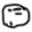
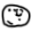
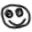
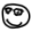
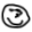
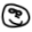
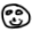
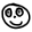
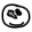
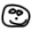
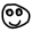
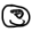
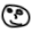
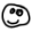
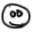
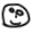
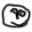
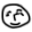
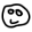
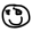
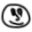
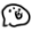
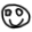
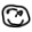
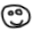
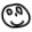
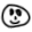
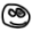
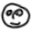
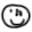
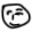
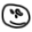
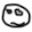
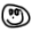
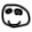
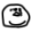
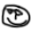
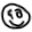
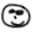
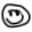
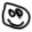
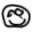
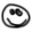
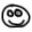
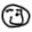
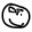
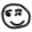
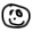
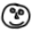
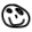
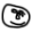
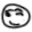
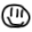
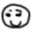
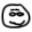
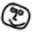
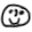
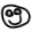
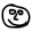
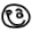
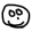
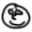
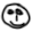
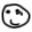
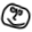
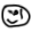
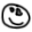
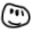

NUTSPosteriorPiN(n_data=50, n_total_samples=200000, n_cached_samples=199932)
3337.6066266459984


In [32]:
post_pi_n_50 = NUTSPosteriorPiN(debug=2, burn=burn, num_steps_per_sample=1, desired_accept_rate=0.6)
post_pi_n_50.fit(data[:50], G, transform_out)

max_images = 4*17
time_mixing = 1_000
_, step_size = post_pi_n_50.reset_samples().run(num_samples=num_samples, permut_samples=True)


bwb_utils.plot_list_of_draws(post_pi_n_50.rvs(max_images), max_images=max_images)

print(post_pi_n_50)
print(post_pi_n_50.total_time)

In [33]:
auto_corr_summary(post_pi_n_50)

The chain is shorter than 1000 times the integrated autocorrelation time for 128 parameter(s). Use this estimate with caution and run a longer chain!
N/1000 = 200;
tau: tensor([1255.3666, 1178.3839, 1618.1091, 1107.5192, 1179.3533, 1170.7426,
        1633.3082, 1332.4681, 1930.9503, 1121.0582, 1025.8684,  925.0061,
        1428.1787, 1082.6715, 1057.1473,  973.0349, 1028.4191, 1529.7744,
        3218.6353, 2180.6477, 1271.6234, 1897.7335, 1398.3896, 1975.8501,
        1089.9026, 2321.4897,  908.0144, 2306.9719, 1213.7896, 1449.2246,
        1953.5679, 1384.6517, 1318.5562, 1222.8745, 1458.8357, 1235.9169,
        2098.0837, 1267.5070,  863.1741, 1844.4274, 1756.5837, 1051.6710,
        1151.0974, 1650.5804, 1414.0365,  879.6603, 1042.3845, 1554.1299,
         920.2640, 1420.3851, 2003.9866, 2691.0002, 1628.0201, 1110.5708,
        1939.7299, 1694.1721, 1186.1675, 1752.9197, 2380.9797, 1041.6355,
         693.4948, 1089.3467,  835.6914,  949.5558,  930.3710, 1783.9240,
        1754.1798

In [34]:
data_ = data[:50]
for i, z in enumerate(post_pi_n_50.samples_history[-10:]):
    print(i, _log_likelihood_true_latent(z, data_, G, transform_out), _log_likelihood_latent(z, data_, G, transform_out))

0 tensor(-299.1693, device='cuda:0') tensor(-299.1693, device='cuda:0')
1 tensor(-299.1693, device='cuda:0') tensor(-299.1693, device='cuda:0')
2 tensor(-299.1693, device='cuda:0') tensor(-299.1693, device='cuda:0')
3 tensor(-297.8386, device='cuda:0') tensor(-297.8387, device='cuda:0')
4 tensor(-297.8386, device='cuda:0') tensor(-297.8387, device='cuda:0')
5 tensor(-297.8387, device='cuda:0') tensor(-297.8387, device='cuda:0')
6 tensor(-297.8387, device='cuda:0') tensor(-297.8387, device='cuda:0')
7 tensor(-297.8386, device='cuda:0') tensor(-297.8387, device='cuda:0')
8 tensor(-297.8386, device='cuda:0') tensor(-297.8387, device='cuda:0')
9 tensor(-297.8387, device='cuda:0') tensor(-297.8387, device='cuda:0')


Sampling (Sampler.HMC; Integrator.IMPLICIT)
Time spent  | Time remain.| Progress             | Samples       | Samples/sec
Final Adapted Step Size:  0.072112075984478----- |    393/200400 | 63.86       
0d:00:53:10 | 0d:00:00:00 | #################### | 200400/200400 | 62.81       
Acceptance Rate 0.50



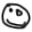
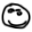
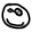
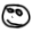
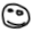
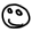
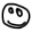
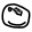
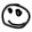
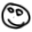
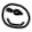
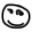
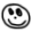
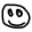
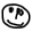
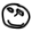
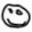
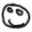
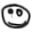
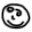
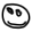
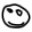
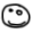
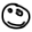
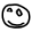
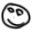
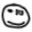
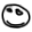
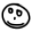
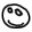
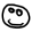
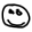
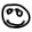
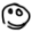
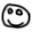
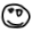
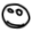
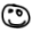
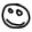
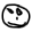
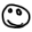
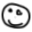
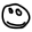
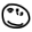
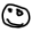
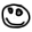
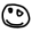
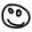
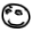
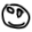
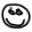
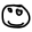
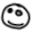
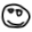
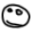
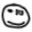
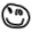
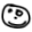
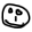
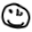
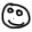
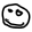
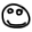
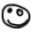
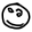
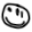
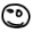
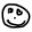


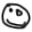
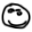
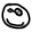
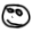
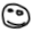
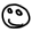
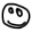
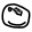
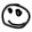
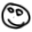
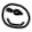
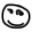
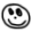
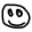
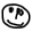
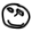
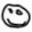
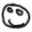
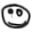
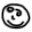
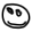
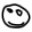
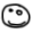
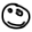
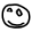
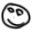
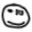
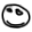
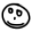
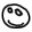
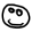
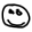
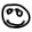
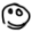
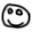
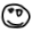
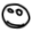
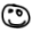
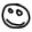
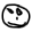
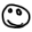
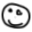
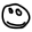
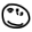
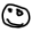
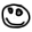
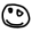
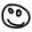
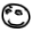
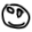
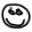
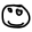
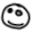
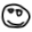
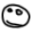
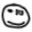
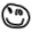
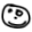
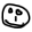
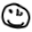
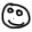
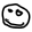
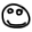
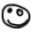
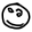
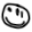
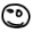
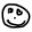

NUTSPosteriorPiN(n_data=100, n_total_samples=200000, n_cached_samples=199932)
3191.640289025001


In [35]:
post_pi_n_100 = NUTSPosteriorPiN(debug=2, burn=400, num_steps_per_sample=1, desired_accept_rate=0.6)
post_pi_n_100.fit(data, G, transform_out)

max_images = 4*17
time_mixing = 1_000
_, step_size = post_pi_n_100.reset_samples().run(num_samples=num_samples, permut_samples=True)


bwb_utils.plot_list_of_draws(post_pi_n_100.rvs(max_images), max_images=max_images)

print(post_pi_n_100)
print(post_pi_n_100.total_time)

In [36]:
auto_corr_summary(post_pi_n_100)

The chain is shorter than 1000 times the integrated autocorrelation time for 128 parameter(s). Use this estimate with caution and run a longer chain!
N/1000 = 200;
tau: tensor([1348.1323, 1524.8784, 1857.7787, 2153.3799, 1216.5616, 1992.0461,
        1103.2809, 2706.5425,  968.1900, 1842.2841, 1332.9728, 1154.4196,
        1643.5035, 1173.4657, 1211.1782, 1543.1790, 1363.9847, 1226.2870,
        1535.1647,  757.6776, 1328.9281,  731.9598, 1571.1857, 1100.1760,
        1482.2157, 1145.5294, 1386.3845,  822.0468, 1376.8906, 1419.5696,
        1321.2183, 1249.6206,  906.0898, 1193.3389, 1743.0319, 2287.3701,
         971.9506, 1375.2382, 3906.4292, 1115.3002, 1829.7930,  936.8973,
        1428.2194, 1568.1622, 1469.5785, 1267.9639, 1147.8777, 1844.2047,
        1679.7249, 1262.5472,  783.9985, 1060.1580, 1586.3445, 1231.0309,
        1926.7820, 1276.1882, 1346.1371, 2856.1814, 2132.8887, 1214.8765,
         928.3964, 1436.7761, 1989.2202, 1432.4772,  959.6077,  935.6520,
        2205.5803

In [37]:
data_ = data
for i, z in enumerate(post_pi_n_100.samples_history[-10:]):
    print(i, _log_likelihood_true_latent(z, data_, G, transform_out), _log_likelihood_latent(z, data_, G, transform_out))

0 tensor(-595.4250, device='cuda:0') tensor(-595.4250, device='cuda:0')
1 tensor(-595.1028, device='cuda:0') tensor(-595.1028, device='cuda:0')
2 tensor(-595.1028, device='cuda:0') tensor(-595.1028, device='cuda:0')
3 tensor(-595.2771, device='cuda:0') tensor(-595.2771, device='cuda:0')
4 tensor(-595.2771, device='cuda:0') tensor(-595.2771, device='cuda:0')
5 tensor(-595.2771, device='cuda:0') tensor(-595.2771, device='cuda:0')
6 tensor(-595.2771, device='cuda:0') tensor(-595.2771, device='cuda:0')
7 tensor(-595.7653, device='cuda:0') tensor(-595.7653, device='cuda:0')
8 tensor(-595.7653, device='cuda:0') tensor(-595.7653, device='cuda:0')
9 tensor(-595.7653, device='cuda:0') tensor(-595.7653, device='cuda:0')


In [72]:
face0

## Hamiltonian Monte Carlo (HMC)

Sampling (Sampler.HMC; Integrator.IMPLICIT)
Time spent  | Time remain.| Progress             | Samples | Samples/sec
0d:00:00:01 | 0d:00:00:00 | #################### | 46/46 | 30.79       
Acceptance Rate 0.37



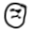
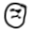
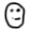
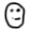
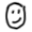
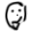
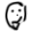
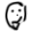
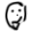
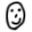
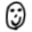
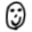
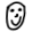
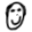
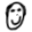
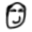
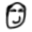
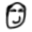
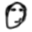
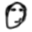
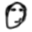
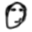
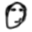
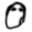
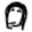
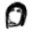
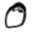
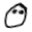
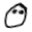
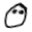
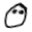
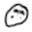
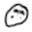
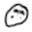
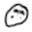
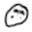


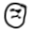
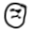
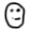
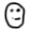
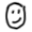
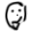
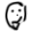
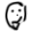
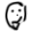
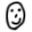
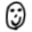
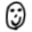
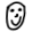
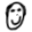
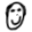
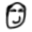
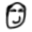
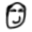
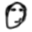
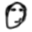
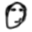
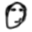
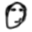
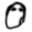
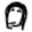
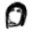
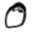
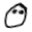
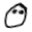
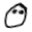
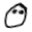
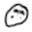
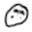
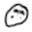
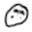
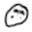

HMCPosteriorPiN(n_data=5, n_total_samples=36)
1.6800036599961459


In [21]:
class HMCPosteriorPiN(LatentMCMCPosteriorPiN):
    def __init__(
            self, 
            log_prob_fn=_log_posterior,
            num_samples=10, 
            num_steps_per_sample=5, 
            burn=10,
            step_size=0.1, 
            **kwargs
        ) -> None:
        super().__init__(
            log_prob_fn=log_prob_fn,
            num_samples=num_samples,
            num_steps_per_sample=num_steps_per_sample,
            burn=burn,
            step_size=step_size,
            sampler=Sampler.HMC,
            **kwargs
        )

post_pi_n = HMCPosteriorPiN()
post_pi_n.fit(data[:5], G, transform_out)

max_images = 4 * 9
post_pi_n.reset_samples().run(num_samples=max_images)

bwb_utils.plot_list_of_draws(post_pi_n.rvs(max_images), max_images=max_images)

print(post_pi_n)
print(post_pi_n.total_time)

## Riemannian Manifold Hamiltonian Monte Carlo (RMHMC)

In [81]:
class RMHMCPosteriorPiN(LatentMCMCPosteriorPiN):
    def __init__(
            self, 
            log_prob_fn=_log_posterior,
            num_samples=10, 
            num_steps_per_sample=5, 
            burn=10,
            step_size=0.1, 
            fixed_point_max_iterations=1000,
            fixed_point_threshold=1e-5,
            explicit_binding_const=100,
            integrator=Integrator.IMPLICIT,
            metric=Metric.HESSIAN,
            **kwargs
        ) -> None:
        super().__init__(
            log_prob_fn=log_prob_fn,
            num_samples=num_samples,
            num_steps_per_sample=num_steps_per_sample,
            burn=burn,
            step_size=step_size,
            fixed_point_max_iterations=fixed_point_max_iterations,
            fixed_point_threshold=fixed_point_threshold,
            explicit_binding_const=explicit_binding_const,
            sampler=Sampler.RMHMC,
            integrator=integrator,
            metric=metric,
            **kwargs
        )

    def _additional_repr(self):
        to_return = super()._additional_repr()
        to_return += f"metric={self.hamiltorch_kwargs['metric'].name}, "
        return to_return
    
post_pi_n = RMHMCPosteriorPiN(step_size=step_size)
post_pi_n

RMHMCPosteriorPiN(metric=HESSIAN)

### Implicit RMHMC

Sampling (Sampler.RMHMC; Integrator.IMPLICIT)
Time spent  | Time remain.| Progress             | Samples | Samples/sec
0d:00:00:39 | 0d:00:00:00 | #################### | 46/46 | 1.21       
Acceptance Rate 0.63



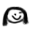
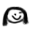
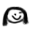
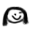
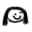
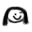
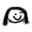
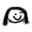
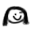
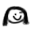
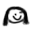
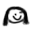
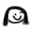
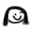
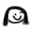
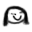
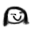
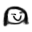
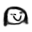
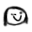
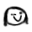
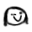
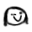
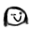
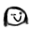
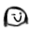
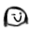
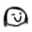
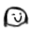
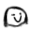
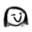
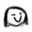
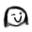
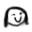
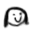
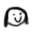


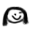
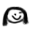
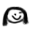
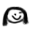
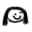
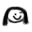
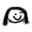
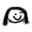
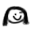
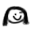
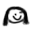
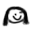
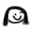
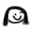
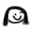
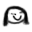
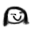
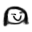
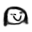
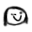
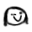
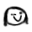
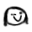
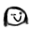
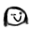
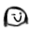
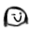
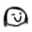
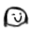
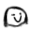
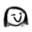
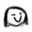
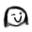
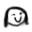
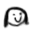
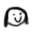

ImplicitRMHMCPosteriorPiN(n_data=5, n_total_samples=36, metric=HESSIAN, fixed_point_max_iterations=1000, fixed_point_threshold=1e-05)
39.46778077899944


In [82]:
class ImplicitRMHMCPosteriorPiN(RMHMCPosteriorPiN):
    def __init__(
            self, 
            log_prob_fn=_log_posterior, 
            num_samples=10, 
            num_steps_per_sample=10, 
            burn=10,
            step_size=0.1, 
            fixed_point_max_iterations=1000,
            fixed_point_threshold=1e-5,
            metric=Metric.HESSIAN,
            **kwargs
        ) -> None:
        super().__init__(
            log_prob_fn=log_prob_fn,
            num_samples=num_samples,
            num_steps_per_sample=num_steps_per_sample,
            burn=burn,
            step_size=step_size,
            integrator=Integrator.IMPLICIT,
            metric=metric,
            fixed_point_max_iterations=fixed_point_max_iterations,
            fixed_point_threshold=fixed_point_threshold,
            **kwargs
        )

    def _additional_repr(self):
        to_return = super()._additional_repr()
        to_return += f"fixed_point_max_iterations={self.hamiltorch_kwargs['fixed_point_max_iterations']}, "
        to_return += f"fixed_point_threshold={self.hamiltorch_kwargs['fixed_point_threshold']}, "
        return to_return

        
post_pi_n = ImplicitRMHMCPosteriorPiN(num_steps_per_sample=1)
post_pi_n.fit(data[:5], G, transform_out)

max_images = 4 * 9
num_samples = max_images
post_pi_n.reset_samples().run(num_samples=num_samples)


bwb_utils.plot_list_of_draws(post_pi_n.rvs(max_images), max_images=max_images)

print(post_pi_n)
print(post_pi_n.total_time)

### Explicit RMHMC

Sampling (Sampler.RMHMC; Integrator.EXPLICIT)
Time spent  | Time remain.| Progress             | Samples | Samples/sec
0d:00:05:58 | 0d:00:00:00 | #################### | 46/46 | 0.13       
Acceptance Rate 0.22



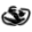
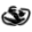
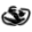
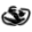
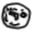
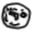
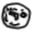
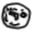
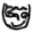
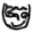
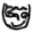
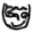
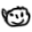
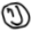
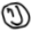
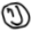
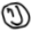
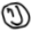
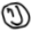
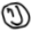
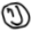
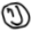
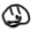
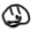
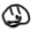
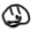
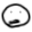
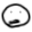
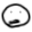
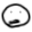
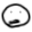
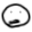
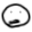
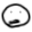
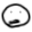
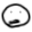


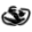
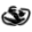
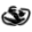
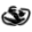
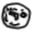
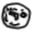
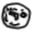
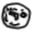
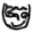
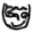
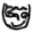
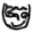
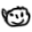
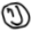
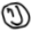
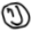
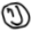
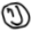
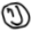
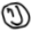
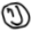
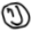
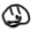
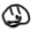
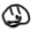
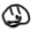
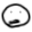
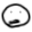
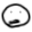
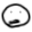
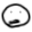
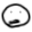
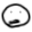
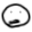
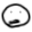
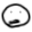

ExplicitRMHMCPosteriorPiN(n_data=5, n_total_samples=36, metric=HESSIAN, explicit_binding_const=100)
358.25699423299375


In [24]:
class ExplicitRMHMCPosteriorPiN(RMHMCPosteriorPiN):
    def __init__(
            self, 
            log_prob_fn=_log_posterior, 
            num_samples=10, 
            num_steps_per_sample=10, 
            burn=10,
            step_size=0.1, 
            explicit_binding_const=100,
            metric=Metric.HESSIAN,
            **kwargs
        ) -> None:
        super().__init__(
            log_prob_fn=log_prob_fn,
            num_samples=num_samples,
            num_steps_per_sample=num_steps_per_sample,
            burn=burn,
            step_size=step_size,
            integrator=Integrator.EXPLICIT,
            metric=metric,
            explicit_binding_const=explicit_binding_const,
            **kwargs
        )

    def _additional_repr(self):
        to_return = super()._additional_repr()
        to_return += f"explicit_binding_const={self.hamiltorch_kwargs['explicit_binding_const']}, "
        return to_return

        
post_pi_n = ExplicitRMHMCPosteriorPiN()
post_pi_n.fit(data[:5], G, transform_out)

max_images = 4 * 9
post_pi_n.reset_samples().run(num_samples=max_images)


bwb_utils.plot_list_of_draws(post_pi_n.rvs(max_images), max_images=max_images)

print(post_pi_n)
print(post_pi_n.total_time)

# Experimentos

In [25]:
import traceback


def mcmc_experiment(data, num_steps_per_sample, burn=50, G=G, transform_out=transform_out, max_images=4*9):
    try:
        post_pi_n = NUTSPosteriorPiN(burn=burn, num_steps_per_sample=num_steps_per_sample, desired_accept_rate=0.3)
        post_pi_n.fit(data, G, transform_out)

        post_pi_n.reset_samples().run(num_samples=max_images)

        bwb_utils.plot_list_of_draws(post_pi_n.rvs(max_images), max_images=max_images)

        print(f"{post_pi_n = }")
        print(f"{post_pi_n.total_time = :.4f}")
    except:
        traceback.print_exc()

## Num steps per sample = 10

In [26]:
num_steps_ps = 10

### N Data = 5

Sampling (Sampler.HMC; Integrator.IMPLICIT)
Time spent  | Time remain.| Progress             | Samples | Samples/sec
Invalid log_prob: -inf, params: tensor([-9.1347e+19,  1.0690e+19, -1.0814e+20, -5.8279e+19,  2.2210e+20,
        -5.2958e+19,  9.2956e+19,  7.7973e+19,  9.1320e+19, -5.0466e+19,
         8.1530e+19,  1.0804e+20,  1.2859e+20,  7.5555e+19,  1.0153e+20,
         8.3185e+19, -9.0650e+19, -8.2898e+19, -1.6399e+19, -1.0549e+20,
        -1.1612e+20,  9.5250e+19, -6.7114e+18, -1.4381e+20,  8.5749e+19,
        -3.3366e+19, -1.9662e+20, -1.1429e+19,  4.8046e+19,  9.6364e+19,
        -2.4192e+19,  8.0702e+19, -2.6134e+19,  1.8467e+20, -5.1753e+17,
         9.2168e+18, -2.2344e+20, -1.5178e+20, -2.4619e+19, -4.7930e+19,
         1.3014e+20, -2.5767e+19, -2.6619e+20,  1.6134e+19, -4.4289e+19,
        -1.5196e+19, -1.1998e+20, -3.6631e+19,  6.3764e+19,  1.2470e+20,
        -3.7042e+19,  7.8679e+19, -4.3968e+19,  1.3702e+20, -9.1717e+19,
         7.7853e+19,  1.6384e+20,  5.0226e+17, -


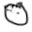
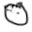
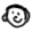
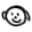
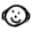
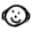
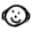
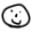
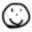
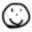
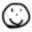
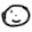
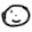
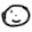
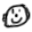
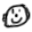
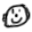
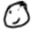
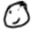
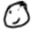
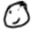
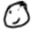
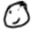
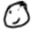
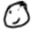
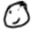
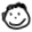
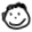
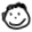
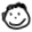
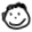
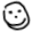
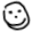


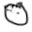
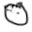
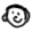
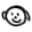
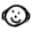
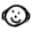
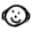
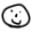
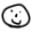
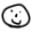
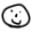
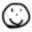
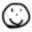
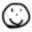
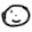
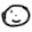
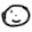
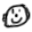
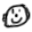
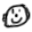
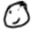
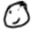
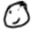
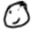
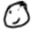
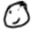
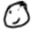
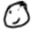
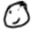
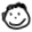
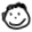
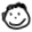
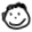
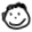
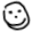
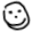

post_pi_n = NUTSPosteriorPiN(n_data=5, n_total_samples=36)
post_pi_n.total_time = 4.5769


In [27]:
n_data = 5
mcmc_experiment(data[:n_data], num_steps_per_sample=num_steps_ps)

### N Data = 10

Sampling (Sampler.HMC; Integrator.IMPLICIT)
Time spent  | Time remain.| Progress             | Samples | Samples/sec
Final Adapted Step Size:  0.08853427320718765--- | 46/86 | 19.79       
0d:00:00:04 | 0d:00:00:00 | #################### | 86/86 | 19.88       
Acceptance Rate 0.22



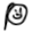
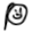
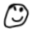
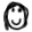
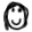
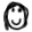
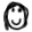
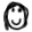
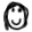
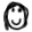
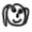
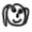
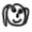
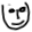
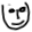
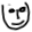
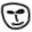
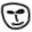
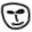
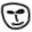
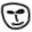
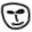
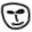
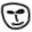
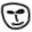
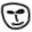
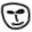
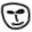
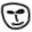
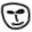
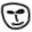
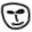
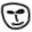
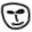
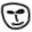
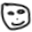


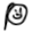
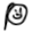
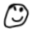
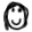
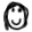
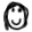
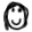
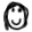
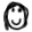
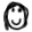
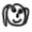
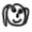
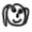
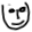
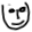
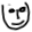
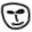
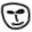
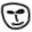
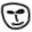
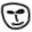
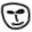
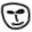
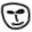
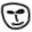
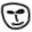
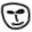
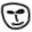
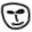
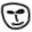
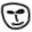
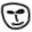
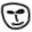
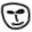
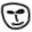
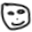

post_pi_n = NUTSPosteriorPiN(n_data=10, n_total_samples=36)
post_pi_n.total_time = 4.5230


In [28]:
n_data = 10
mcmc_experiment(data[:n_data], num_steps_per_sample=num_steps_ps)

### N Data = 25

Sampling (Sampler.HMC; Integrator.IMPLICIT)
Time spent  | Time remain.| Progress             | Samples | Samples/sec
Final Adapted Step Size:  0.031092653051018715-- | 49/86 | 18.16       
0d:00:00:04 | 0d:00:00:00 | #################### | 86/86 | 18.76       
Acceptance Rate 0.29



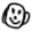
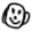
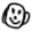
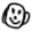
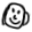
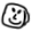
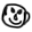
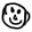
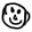
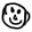
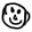
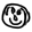
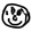
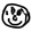
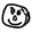
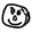
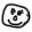
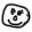
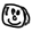
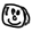
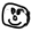
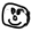
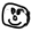
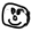
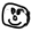
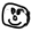
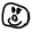
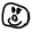
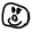
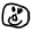
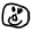


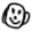
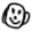
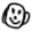
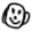
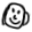
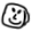
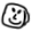
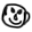
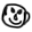
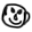
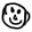
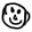
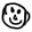
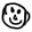
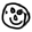
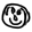
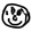
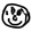
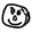
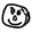
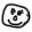
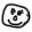
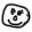
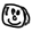
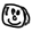
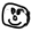
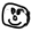
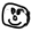
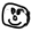
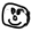
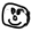
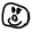
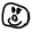
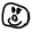
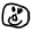
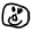

post_pi_n = NUTSPosteriorPiN(n_data=25, n_total_samples=36)
post_pi_n.total_time = 4.7822


In [29]:
n_data = 25
mcmc_experiment(data[:n_data], num_steps_per_sample=num_steps_ps)

### N Data = 50

Sampling (Sampler.HMC; Integrator.IMPLICIT)
Time spent  | Time remain.| Progress             | Samples | Samples/sec
Invalid log_prob: -inf, params: tensor([ 4.2054e+19,  7.1910e+19, -8.8024e+19,  4.9091e+19, -2.8528e+19,
        -1.3819e+19,  4.0830e+19, -2.8167e+19,  4.8983e+19, -5.4495e+18,
        -7.3827e+19,  3.4408e+19, -5.3118e+18,  5.7811e+19, -1.7828e+19,
        -1.6849e+19,  3.6041e+19, -3.4008e+19, -7.4520e+18, -8.1457e+19,
         5.2755e+19, -1.4233e+18, -1.6136e+19, -1.0107e+20, -1.9295e+18,
        -6.7064e+18,  2.9068e+19, -6.5525e+19,  4.3164e+19,  1.7098e+19,
         5.6135e+19,  2.8673e+19,  7.0308e+19,  1.6556e+19, -3.4542e+19,
         8.4270e+18,  5.3666e+19,  5.9350e+19,  6.5229e+18, -1.0915e+19,
        -6.8300e+18, -2.8125e+19, -2.0104e+19, -1.5540e+18, -8.6174e+19,
        -8.3579e+19, -3.4918e+19, -4.2014e+19,  2.5905e+19,  4.8870e+19,
         3.3966e+19,  3.5217e+19,  2.9468e+19,  1.4733e+19,  2.4053e+19,
        -2.1290e+19,  3.9626e+19, -4.6783e+19, -


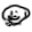
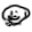
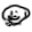
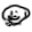
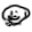
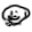
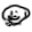
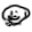
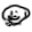
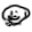
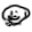
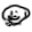
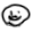
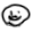
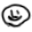
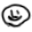
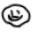
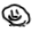
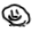
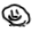
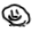
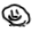
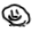
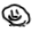
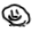
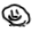
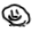
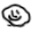
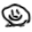
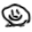
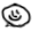
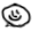
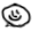
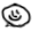
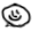
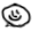


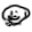
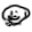
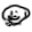
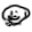
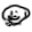
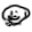
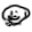
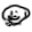
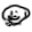
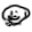
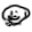
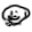
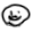
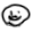
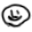
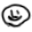
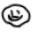
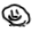
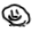
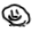
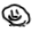
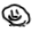
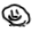
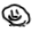
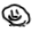
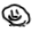
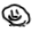
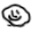
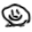
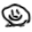
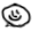
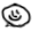
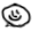
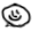
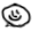
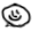

post_pi_n = NUTSPosteriorPiN(n_data=50, n_total_samples=36)
post_pi_n.total_time = 4.6136


In [30]:
n_data = 50
mcmc_experiment(data[:n_data], num_steps_per_sample=num_steps_ps)

---

## Num steps per sample = 50

In [31]:
num_steps_ps = 50

### N Data = 5

Sampling (Sampler.HMC; Integrator.IMPLICIT)


Time spent  | Time remain.| Progress             | Samples | Samples/sec
Invalid log_prob: nan, params: tensor([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan], device='cuda:0',
       requires_grad=True)
Invalid log_prob: -inf, params: tensor([-5.3916e+31, -8.2845e+30, -1.1480e+31, -3.9436e+30, -2.4553e+31,
        -1.2299e+31,  1.1844e+32,  4.3037e+30, -1.0586e+32


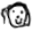
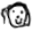
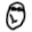
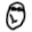
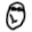
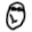
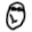
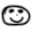
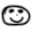
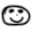
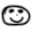
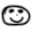
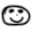
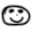
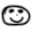
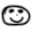
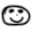
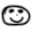
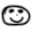
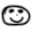
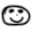
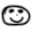
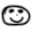
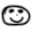
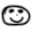
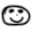
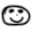
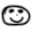
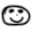
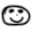
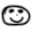
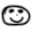
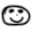


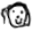
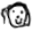
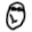
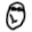
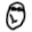
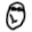
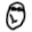
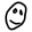
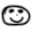
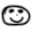
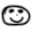
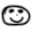
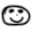
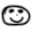
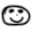
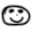
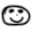
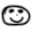
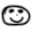
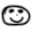
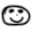
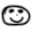
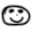
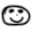
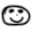
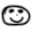
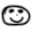
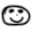
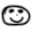
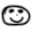
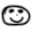
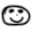
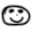
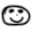
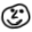

post_pi_n = NUTSPosteriorPiN(n_data=5, n_total_samples=36)
post_pi_n.total_time = 19.7749


In [32]:
n_data = 5
mcmc_experiment(data[:n_data], num_steps_per_sample=num_steps_ps)

### N Data = 10

Sampling (Sampler.HMC; Integrator.IMPLICIT)
Time spent  | Time remain.| Progress             | Samples | Samples/sec
Invalid log_prob: -inf, params: tensor([ 5.2538e+31,  8.1822e+31, -1.1762e+32,  2.2761e+32, -1.4629e+32,
         5.4596e+30,  7.0875e+31, -2.2347e+31, -1.2163e+32, -1.6259e+32,
        -2.4480e+31,  2.5967e+31,  5.8514e+30,  9.2454e+31, -4.6791e+31,
        -1.4580e+31, -6.9324e+31,  3.3663e+31, -2.4844e+31,  1.5922e+31,
        -1.2823e+31, -4.5485e+31, -6.0257e+31,  3.1481e+31, -5.2873e+31,
        -4.5685e+31, -2.9276e+31,  1.2150e+32, -3.3892e+31,  7.2780e+31,
        -5.1942e+31,  4.3722e+31,  7.0093e+31, -7.7425e+31,  4.6746e+31,
         3.6492e+30, -1.1852e+32, -3.3432e+31,  1.1607e+32, -7.4005e+31,
        -4.5178e+30,  3.4172e+31, -8.7328e+31,  3.5905e+30,  1.0696e+31,
        -1.0604e+32,  1.2099e+30, -6.8008e+31, -8.0077e+31,  3.8951e+31,
         1.0558e+32,  5.2964e+31,  5.5974e+31,  6.3050e+31, -6.1270e+31,
         1.0935e+32, -1.1263e+31,  2.9760e+31, -


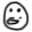
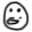
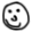
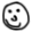
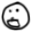
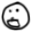
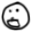
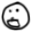
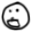
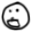
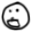
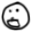
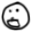
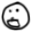
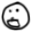
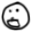
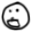
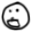
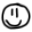
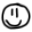
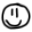
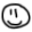
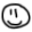
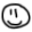
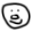
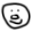
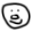
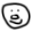
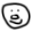
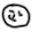
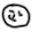
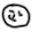
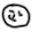
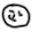
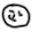
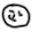


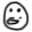
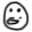
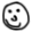
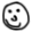
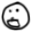
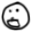
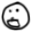
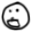
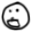
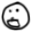
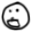
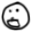
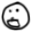
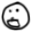
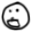
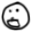
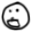
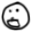
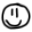
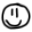
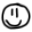
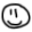
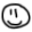
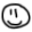
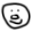
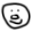
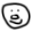
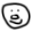
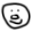
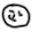
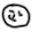
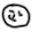
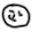
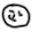
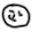
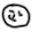

post_pi_n = NUTSPosteriorPiN(n_data=10, n_total_samples=36)
post_pi_n.total_time = 18.7328


In [33]:
n_data = 10
mcmc_experiment(data[:n_data], num_steps_per_sample=num_steps_ps)

### N Data = 25

Sampling (Sampler.HMC; Integrator.IMPLICIT)
Time spent  | Time remain.| Progress             | Samples | Samples/sec
Final Adapted Step Size:  0.01409215573221445--- | 50/86 | 4.45       
0d:00:00:19 | 0d:00:00:00 | #################### | 86/86 | 4.54       
Acceptance Rate 0.22



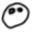
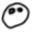
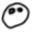
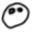
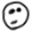
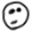
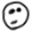
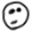
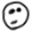
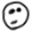
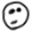
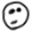
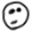
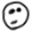
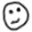
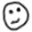
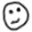
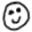
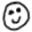
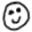
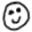
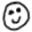
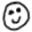
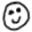
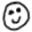
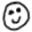
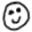
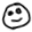
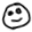
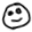
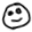
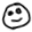
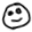
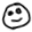
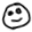
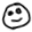


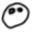
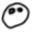
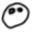
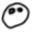
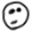
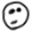
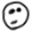
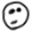
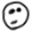
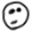
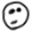
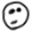
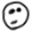
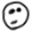
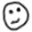
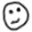
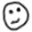
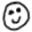
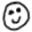
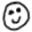
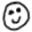
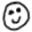
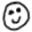
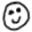
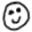
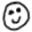
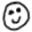
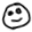
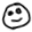
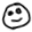
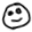
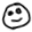
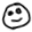
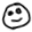
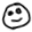
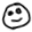

post_pi_n = NUTSPosteriorPiN(n_data=25, n_total_samples=36)
post_pi_n.total_time = 19.3533


In [34]:
n_data = 25
mcmc_experiment(data[:n_data], num_steps_per_sample=num_steps_ps)

### N Data = 50

Sampling (Sampler.HMC; Integrator.IMPLICIT)
Time spent  | Time remain.| Progress             | Samples | Samples/sec
Invalid log_prob: nan, params: tensor([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan], device='cuda:0',
       requires_grad=True)
Invalid log_prob: -inf, params: tensor([-6.2117e+31, -3.9506e+31, -7.8498e+31,  6.5532e+31, -1.3818e+32,
        -5.797


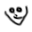
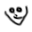
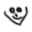
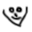
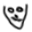
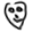
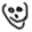
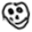
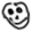
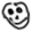
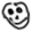
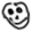
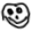
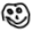
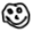
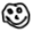
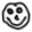
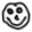
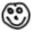
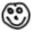
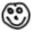
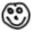
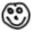
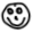
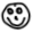
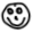
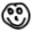
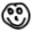
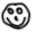
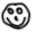
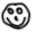


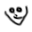
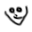
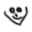
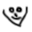
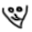
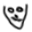
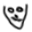
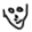
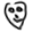
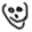
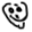
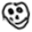
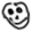
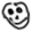
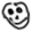
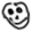
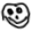
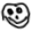
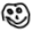
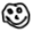
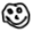
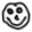
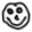
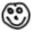
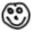
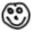
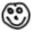
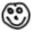
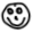
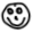
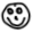
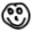
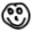
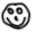
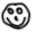
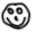

post_pi_n = NUTSPosteriorPiN(n_data=50, n_total_samples=36)
post_pi_n.total_time = 23.0007


In [35]:
n_data = 50
mcmc_experiment(data[:n_data], num_steps_per_sample=num_steps_ps)

---

## Num steps per sample = 100

In [36]:
num_steps_ps = 100

### N Data = 5

Sampling (Sampler.HMC; Integrator.IMPLICIT)
Time spent  | Time remain.| Progress             | Samples | Samples/sec
Invalid log_prob: nan, params: tensor([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan], device='cuda:0',
       requires_grad=True)
Invalid log_prob: nan, params: tensor([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 


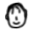
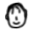
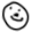
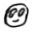
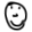
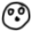
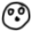
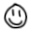
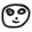
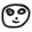
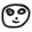
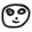
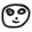
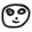
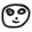
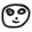
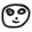
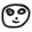
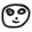
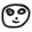
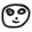
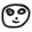
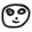
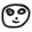
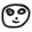
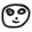
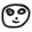
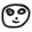
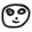
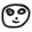
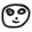
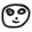
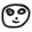
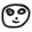
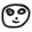
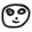


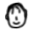
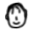
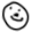
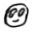
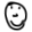
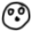
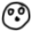
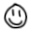
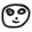
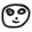
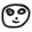
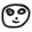
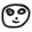
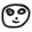
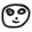
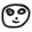
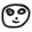
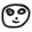
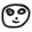
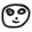
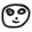
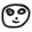
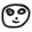
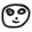
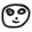
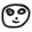
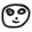
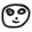
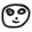
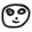
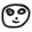
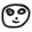
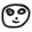
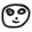
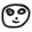
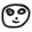

post_pi_n = NUTSPosteriorPiN(n_data=5, n_total_samples=36)
post_pi_n.total_time = 37.6000


In [37]:
n_data = 5
mcmc_experiment(data[:n_data], num_steps_per_sample=num_steps_ps)

### N Data = 10

Sampling (Sampler.HMC; Integrator.IMPLICIT)
Time spent  | Time remain.| Progress             | Samples | Samples/sec
Final Adapted Step Size:  0.002746457699686289-- | 50/86 | 2.10       
0d:00:00:41 | 0d:00:00:00 | #################### | 86/86 | 2.11       
Acceptance Rate 0.30



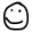
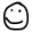
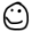
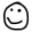
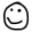
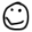
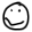
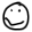
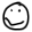
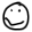
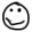
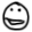
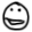
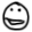
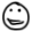
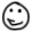
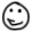
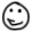
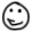
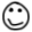
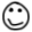
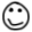
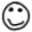
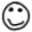
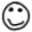
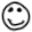
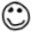
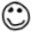
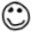
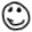
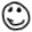
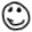
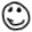
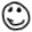
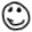


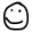
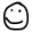
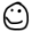
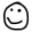
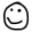
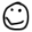
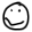
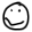
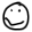
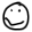
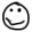
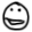
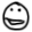
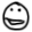
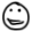
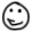
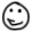
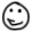
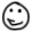
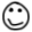
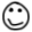
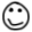
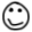
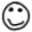
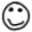
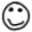
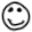
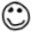
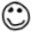
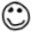
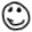
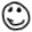
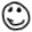
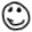
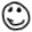
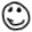

post_pi_n = NUTSPosteriorPiN(n_data=10, n_total_samples=36)
post_pi_n.total_time = 41.3337


In [38]:
n_data = 10
mcmc_experiment(data[:n_data], num_steps_per_sample=num_steps_ps)

### N Data = 25

Sampling (Sampler.HMC; Integrator.IMPLICIT)
Time spent  | Time remain.| Progress             | Samples | Samples/sec
Invalid log_prob: nan, params: tensor([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan], device='cuda:0',
       requires_grad=True)
Final Adapted Step Size:  0.004768165294080973-- | 50/86 | 2.19       
0d:00:00:39 | 0d:00:00:00 | ####################


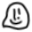
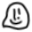
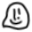
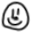
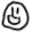
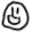
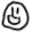
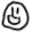
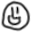
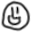
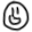
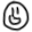
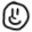
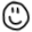
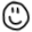
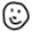
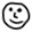
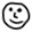
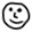
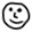
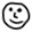
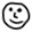
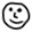
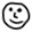
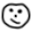
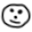
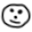
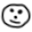
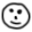
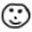
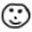
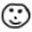
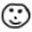
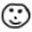
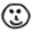
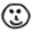


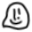
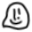
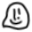
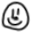
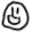
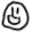
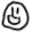
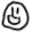
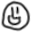
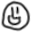
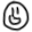
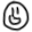
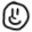
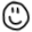
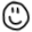
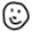
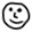
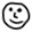
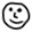
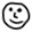
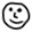
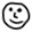
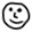
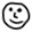
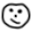
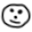
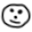
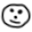
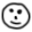
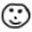
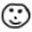
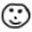
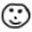
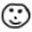
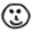
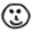

post_pi_n = NUTSPosteriorPiN(n_data=25, n_total_samples=36)
post_pi_n.total_time = 39.7527


In [39]:
n_data = 25
mcmc_experiment(data[:n_data], num_steps_per_sample=num_steps_ps)

### N Data = 50

Sampling (Sampler.HMC; Integrator.IMPLICIT)
Time spent  | Time remain.| Progress             | Samples | Samples/sec
Final Adapted Step Size:  0.002684555947780609-- | 50/86 | 2.42       
0d:00:00:37 | 0d:00:00:00 | #################### | 86/86 | 2.30       
Acceptance Rate 0.26



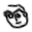
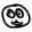
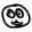
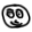
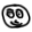
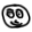
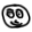
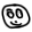
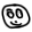
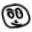
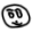
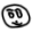
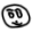
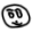
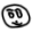
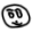
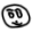
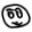
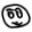
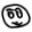
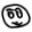
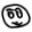
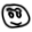
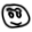
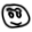
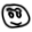
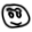
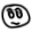
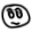
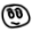
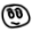
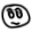
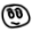
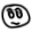
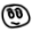
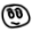


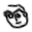
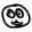
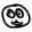
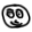
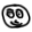
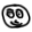
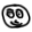
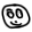
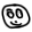
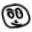
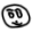
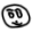
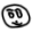
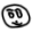
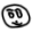
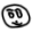
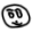
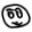
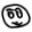
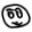
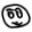
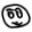
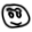
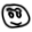
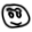
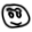
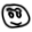
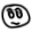
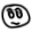
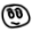
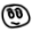
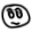
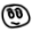
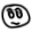
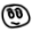
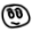

post_pi_n = NUTSPosteriorPiN(n_data=50, n_total_samples=36)
post_pi_n.total_time = 38.0595


In [40]:
n_data = 50
mcmc_experiment(data[:n_data], num_steps_per_sample=num_steps_ps)

---

## Num steps per sample = 500

In [41]:
num_steps_ps = 500

### N Data = 5

Sampling (Sampler.HMC; Integrator.IMPLICIT)
Time spent  | Time remain.| Progress             | Samples | Samples/sec
Final Adapted Step Size:  0.001687122625298798-- | 50/86 | 0.47       
0d:00:03:02 | 0d:00:00:00 | #################### | 86/86 | 0.48       
Acceptance Rate 0.22



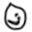
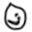
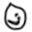
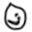
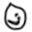
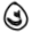
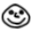
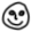
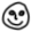
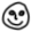
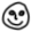
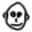
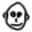
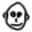
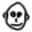
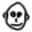
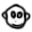
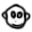
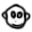
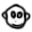
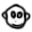
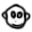
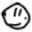
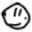
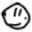
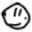
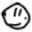
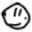
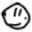
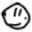
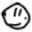
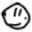
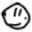
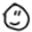
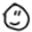
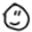


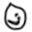
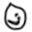
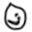
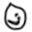
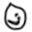
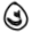
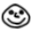
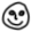
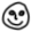
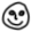
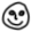
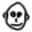
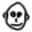
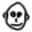
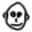
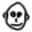
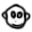
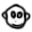
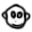
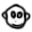
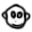
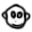
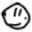
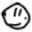
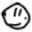
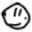
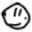
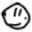
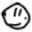
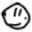
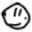
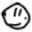
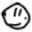
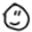
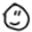
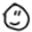

post_pi_n = NUTSPosteriorPiN(n_data=5, n_total_samples=36)
post_pi_n.total_time = 182.4809


In [42]:
n_data = 5
mcmc_experiment(data[:n_data], num_steps_per_sample=num_steps_ps)

### N Data = 10

Sampling (Sampler.HMC; Integrator.IMPLICIT)
Time spent  | Time remain.| Progress             | Samples | Samples/sec
Invalid log_prob: nan, params: tensor([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan], device='cuda:0',
       requires_grad=True)
Invalid log_prob: nan, params: tensor([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 


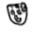
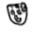
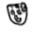
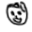
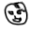
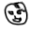
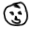
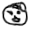
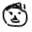
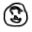
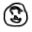
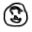
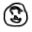
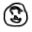
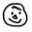
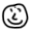
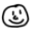
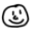
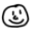
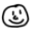
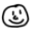
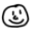
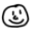
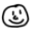
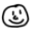
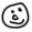
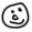
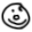
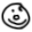
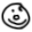
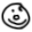
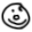
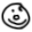
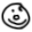
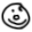
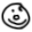


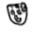
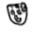
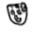
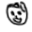
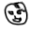
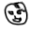
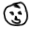
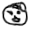
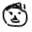
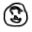
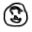
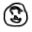
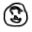
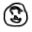
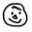
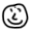
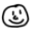
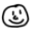
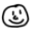
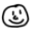
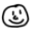
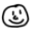
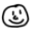
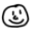
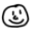
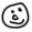
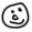
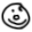
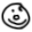
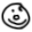
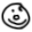
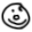
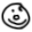
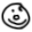
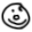
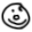

post_pi_n = NUTSPosteriorPiN(n_data=10, n_total_samples=36)
post_pi_n.total_time = 163.6162


In [43]:
n_data = 10
mcmc_experiment(data[:n_data], num_steps_per_sample=num_steps_ps)

### N Data = 25

Sampling (Sampler.HMC; Integrator.IMPLICIT)
Time spent  | Time remain.| Progress             | Samples | Samples/sec
Invalid log_prob: nan, params: tensor([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan], device='cuda:0',
       requires_grad=True)
Invalid log_prob: nan, params: tensor([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 


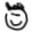
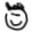
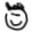
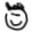
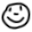
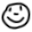
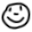
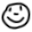
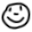
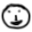
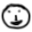
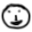
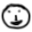
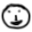
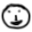
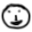
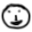
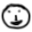
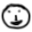
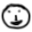
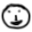
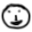
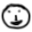
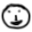
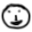
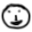
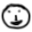
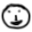
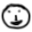
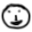
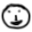
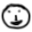
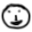
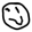
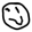
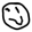


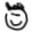
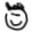
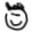
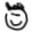
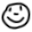
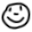
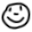
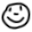
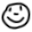
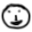
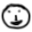
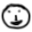
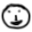
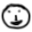
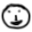
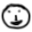
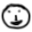
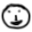
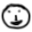
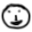
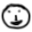
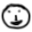
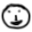
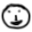
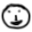
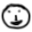
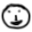
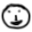
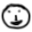
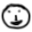
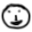
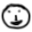
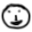
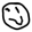
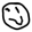
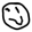

post_pi_n = NUTSPosteriorPiN(n_data=25, n_total_samples=36)
post_pi_n.total_time = 169.6197


In [44]:
n_data = 25
mcmc_experiment(data[:n_data], num_steps_per_sample=num_steps_ps)

### N Data = 50

Sampling (Sampler.HMC; Integrator.IMPLICIT)
Time spent  | Time remain.| Progress             | Samples | Samples/sec
Final Adapted Step Size:  0.0003974107385147363- | 50/86 | 0.55       
0d:00:02:41 | 0d:00:00:00 | #################### | 86/86 | 0.54       
Acceptance Rate 0.28



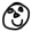
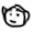
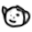
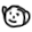
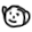
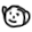
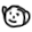
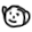
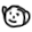
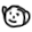
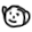
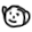
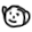
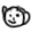
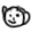
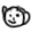
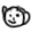
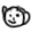
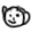
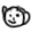
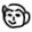
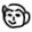
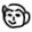
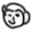
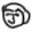
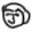
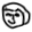
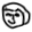
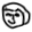
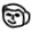
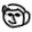
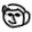
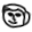
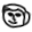
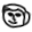
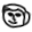


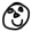
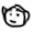
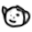
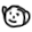
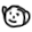
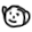
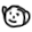
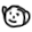
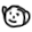
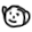
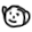
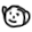
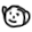
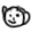
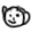
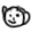
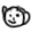
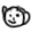
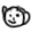
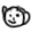
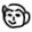
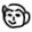
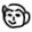
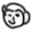
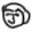
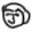
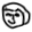
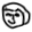
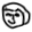
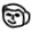
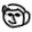
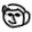
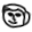
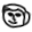
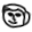
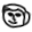

post_pi_n = NUTSPosteriorPiN(n_data=50, n_total_samples=36)
post_pi_n.total_time = 161.9211


In [45]:
n_data = 50
mcmc_experiment(data[:n_data], num_steps_per_sample=num_steps_ps)

---

## Num steps per sample = 1.000

In [46]:
num_steps_ps = 1_000
burn = 20

### N Data = 5

Sampling (Sampler.HMC; Integrator.IMPLICIT)
Time spent  | Time remain.| Progress             | Samples | Samples/sec


Invalid log_prob: nan, params: tensor([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan], device='cuda:0',
       requires_grad=True)
Invalid log_prob: nan, params: tensor([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,


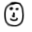
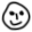
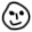
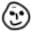
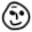
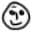
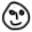
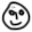
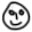
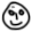
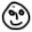
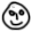
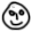
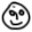
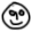
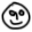
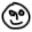
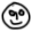
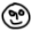
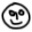
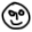
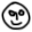
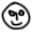
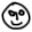
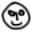
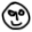
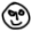
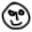
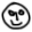
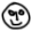
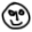
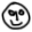
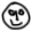
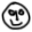
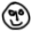
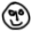


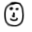
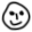
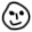
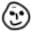
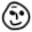
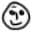
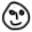
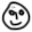
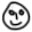
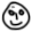
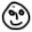
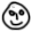
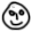
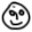
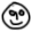
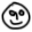
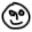
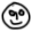
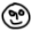
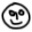
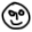
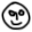
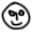
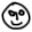
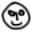
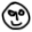
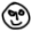
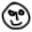
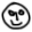
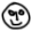
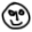
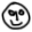
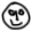
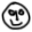
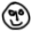
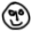

post_pi_n = NUTSPosteriorPiN(n_data=5, n_total_samples=36)
post_pi_n.total_time = 218.1809


In [47]:
n_data = 5
mcmc_experiment(data[:n_data], num_steps_per_sample=num_steps_ps, burn=burn)

### N Data = 10

Sampling (Sampler.HMC; Integrator.IMPLICIT)
Time spent  | Time remain.| Progress             | Samples | Samples/sec
Invalid log_prob: nan, params: tensor([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan], device='cuda:0',
       requires_grad=True)
Invalid log_prob: nan, params: tensor([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 


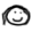
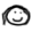
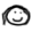
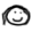
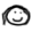
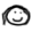
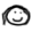
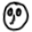
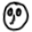
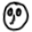
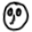
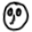
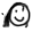
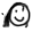
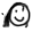
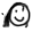
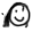
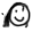
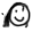
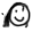
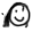
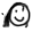
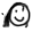
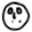
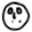
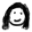
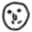
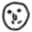
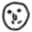
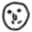
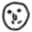
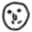
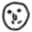
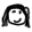
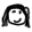
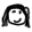


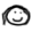
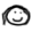
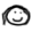
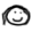
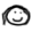
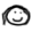
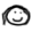
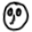
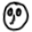
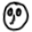
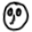
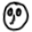
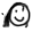
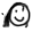
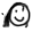
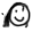
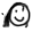
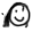
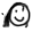
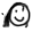
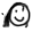
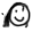
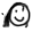
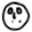
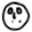
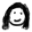
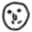
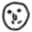
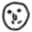
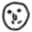
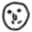
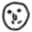
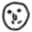
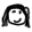
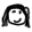
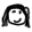

post_pi_n = NUTSPosteriorPiN(n_data=10, n_total_samples=36)
post_pi_n.total_time = 262.2415


In [48]:
n_data = 10
mcmc_experiment(data[:n_data], num_steps_per_sample=num_steps_ps, burn=burn)

### N Data = 25

Sampling (Sampler.HMC; Integrator.IMPLICIT)
Time spent  | Time remain.| Progress             | Samples | Samples/sec
Invalid log_prob: nan, params: tensor([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan], device='cuda:0',
       requires_grad=True)
Final Adapted Step Size:  0.009092516265809536-- | 20/56 | 0.24       
0d:00:03:56 | 0d:00:00:00 | ####################


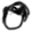
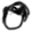
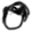
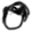
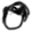
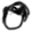
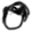
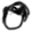
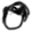
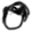
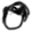
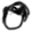
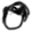
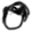
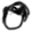
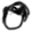
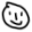
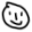
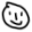
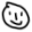
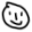
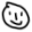
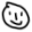
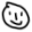
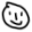
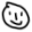
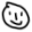
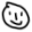
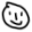
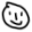
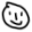
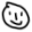
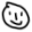
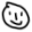
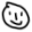
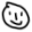


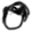
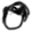
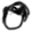
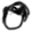
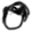
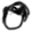
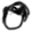
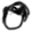
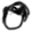
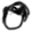
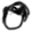
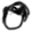
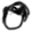
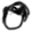
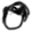
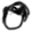
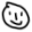
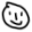
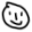
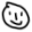
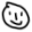
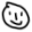
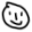
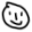
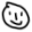
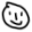
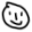
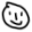
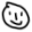
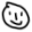
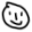
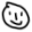
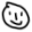
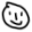
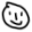
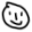

post_pi_n = NUTSPosteriorPiN(n_data=25, n_total_samples=36)
post_pi_n.total_time = 236.9958


In [49]:
n_data = 25
mcmc_experiment(data[:n_data], num_steps_per_sample=num_steps_ps, burn=burn)

### N Data = 50

Sampling (Sampler.HMC; Integrator.IMPLICIT)
Time spent  | Time remain.| Progress             | Samples | Samples/sec
Invalid log_prob: nan, params: tensor([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan], device='cuda:0',
       requires_grad=True)
Invalid log_prob: nan, params: tensor([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 


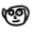
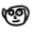
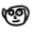
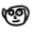
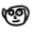
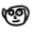
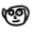
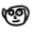
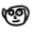
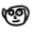
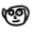
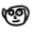
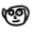
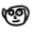
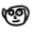
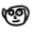
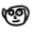
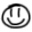
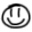
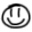
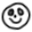
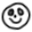
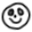
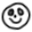
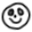
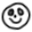
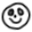
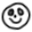
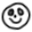
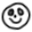
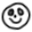
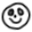
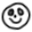
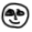
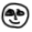
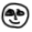


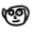
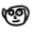
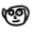
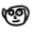
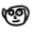
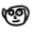
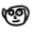
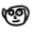
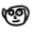
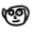
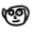
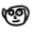
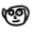
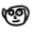
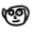
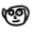
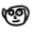
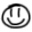
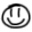
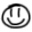
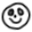
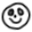
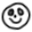
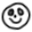
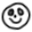
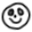
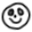
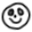
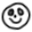
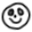
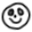
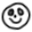
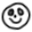
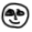
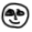
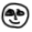

post_pi_n = NUTSPosteriorPiN(n_data=50, n_total_samples=36)
post_pi_n.total_time = 260.2302


In [50]:
n_data = 50
mcmc_experiment(data[:n_data], num_steps_per_sample=num_steps_ps, burn=burn)

---

## Num steps per sample = 10.000

In [51]:
num_steps_ps = 10_000
burn = 10

### N Data = 5

Sampling (Sampler.HMC; Integrator.IMPLICIT)
Time spent  | Time remain.| Progress             | Samples | Samples/sec
Invalid log_prob: nan, params: tensor([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan], device='cuda:0',
       requires_grad=True)
Invalid log_prob: nan, params: tensor([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 


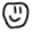
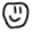
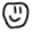
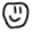
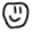
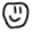
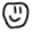
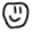
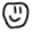
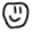
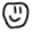
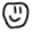
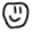
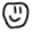
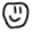
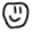
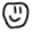
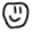
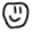
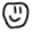
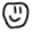
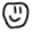
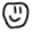
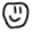
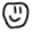
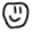
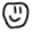
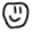
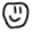
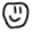
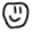
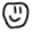
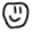
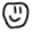
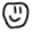
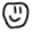


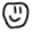
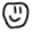
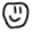
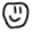
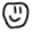
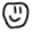
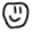
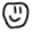
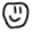
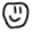
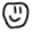
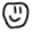
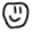
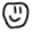
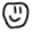
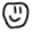
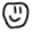
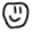
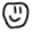
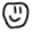
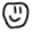
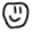
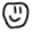
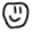
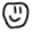
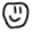
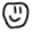
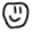
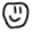
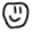
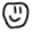
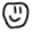
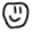
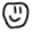
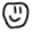
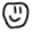

post_pi_n = NUTSPosteriorPiN(n_data=5, n_total_samples=36)
post_pi_n.total_time = 2781.9968


In [52]:
n_data = 5
mcmc_experiment(data[:n_data], num_steps_per_sample=num_steps_ps, burn=burn)

### N Data = 10

In [53]:
n_data = 10
mcmc_experiment(data[:n_data], num_steps_per_sample=num_steps_ps, burn=burn)

Sampling (Sampler.HMC; Integrator.IMPLICIT)
Time spent  | Time remain.| Progress             | Samples | Samples/sec
Invalid log_prob: nan, params: tensor([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan], device='cuda:0',
       requires_grad=True)
Invalid log_prob: nan, params: tensor([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 

Traceback (most recent call last):
  File "/tmp/ipykernel_207882/2574090871.py", line 9, in mcmc_experiment
    post_pi_n.reset_samples().run(num_samples=max_images)
  File "/home/fmunoz/codeProjects/pythonProjects/Bayesian-Learning-with-Wasserstein-Barycenters/bwb/distributions/posterior_distributions.py", line 39, in timeit_wrapper
    result = method(*args, **kwargs)
  File "/tmp/ipykernel_207882/3893860954.py", line 90, in run
    samples = hamiltorch.sample(**hamiltorch_kwargs)
  File "/home/fmunoz/codeProjects/pythonProjects/Bayesian-Learning-with-Wasserstein-Barycenters/.venv/lib/python3.10/site-packages/hamiltorch/samplers.py", line 973, in sample
    leapfrog_params, leapfrog_momenta = leapfrog(params, momentum, log_prob_func, sampler=sampler, integrator=integrator, steps=num_steps_per_sample, step_size=step_size, inv_mass=inv_mass, jitter=jitter, jitter_max_tries=jitter_max_tries, fixed_point_threshold=fixed_point_threshold, fixed_point_max_iterations=fixed_point_max_iteratio

### N Data = 25

In [ ]:
n_data = 25
mcmc_experiment(data[:n_data], num_steps_per_sample=num_steps_ps, burn=burn)

### N Data = 50

In [ ]:
n_data = 50
mcmc_experiment(data[:n_data], num_steps_per_sample=num_steps_ps, burn=burn)